In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import math

In [75]:
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

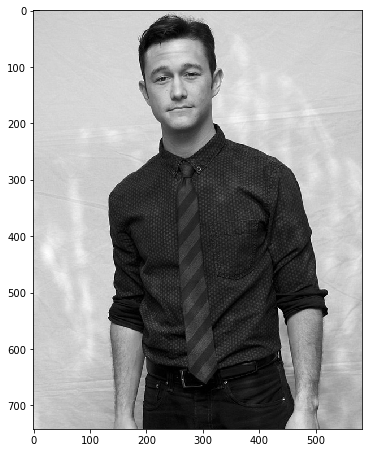

In [76]:
img=(cv2.imread('faces_imgs/5.jpg',cv2.IMREAD_GRAYSCALE))
visualize([img],'gray')

#  Smoothening image - handling noise

In [77]:
def smoothening_gaussian(img):
#     size = int(size) // 2
#     x, y = np.mgrid[-size:size+1, -size:size+1]
    x=np.array([[-2,-1,0,1,2],[-2,-1,0,1,2],[-2,-1,0,1,2],[-2,-1,0,1,2],[-2,-1,0,1,2]])
    y=np.array([[2,2,2,2,2],[1,1,1,1,1],[0,0,0,0,0],[-1,-1,-1,-1,-1],[-2,-2,-2,-2,-2]])
    sigma=1.4
    sigma=2.0 * sigma**2
    g = np.exp(-1*((x**2 + y**2) / sigma))
    g = (1/(sigma*np.pi)) * g 
    grad = signal.convolve2d(img, g, boundary='symm', mode='same')
    return grad

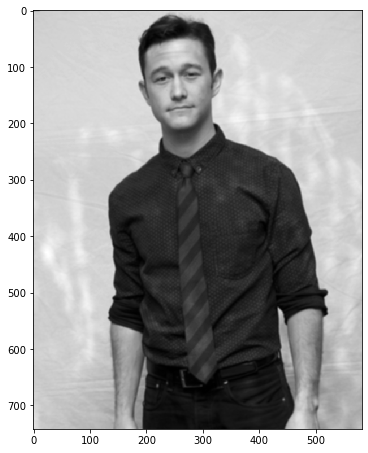

In [78]:
img = smoothening_gaussian(img)
visualize([img],'gray')

# Calculating gradient and direction

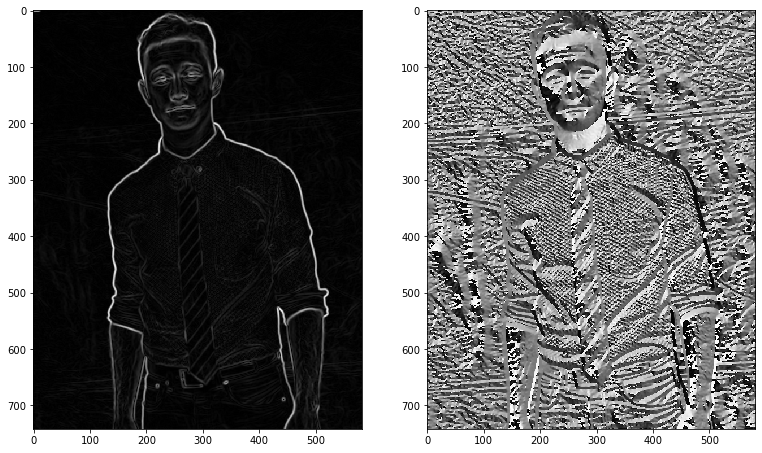

In [79]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
#     visualize([Ix,Iy],'gray')
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)
G, theta = sobel_filters(img)
visualize([G,theta],'gray')

In [80]:
print(type(G[0][0]))

<class 'numpy.float64'>


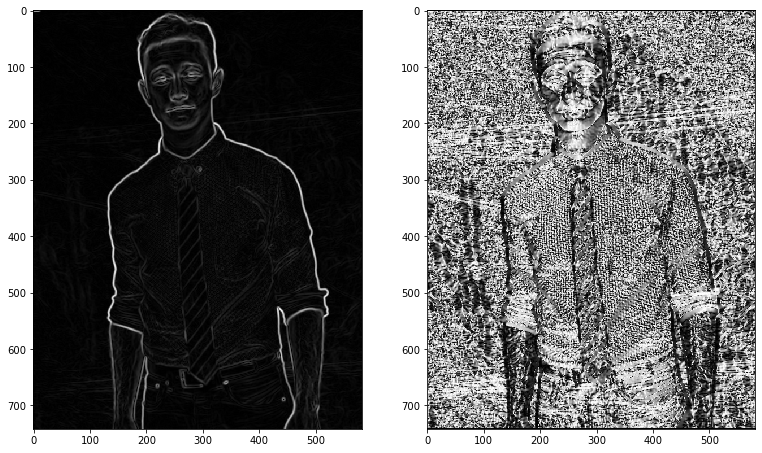

In [81]:
def sobel_op(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3) 
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    mag = cv2.magnitude(sobelx, sobely)
    ang = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return (mag,ang)
mag,ang = sobel_op(img)
visualize([mag,ang],'gray')

# NON MAXIMUM SUPRESSION

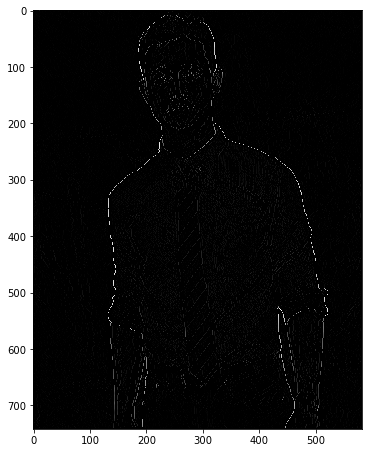

In [102]:
def NonMaxSuppression(mag,ang):
    m,n = mag.shape
    img = np.zeros(mag.shape)
 
    for row in range(0, m - 1):
        for col in range(0, n - 1):
            direction = ang[row, col]
 
            if (0 <= direction < 22.5) or (337.5 <= direction <= 360) or (157.5 <= direction <= 202.5):
                before_pixel = mag[row, col - 1]
                after_pixel = mag[row, col + 1]
 
            elif (22.5 <= direction < 67.5) or (202.5 <= direction < 247.5):
                before_pixel = mag[row + 1, col - 1]
                after_pixel = mag[row - 1, col + 1]
 
            elif ( 67.5 <= direction < 112.5) or ( 247.5 <= direction < 292.5):
                before_pixel = mag[row - 1, col]
                after_pixel = mag[row + 1, col]
 
            else:
                before_pixel = mag[row - 1, col - 1]
                after_pixel = mag[row + 1, col + 1]
 
            if mag[row, col] >= before_pixel and mag[row, col] >= after_pixel:
                img[row, col] = mag[row, col]
    return img
op = NonMaxSuppression(mag,ang)
visualize([op],'gray')
    

# Threshold 

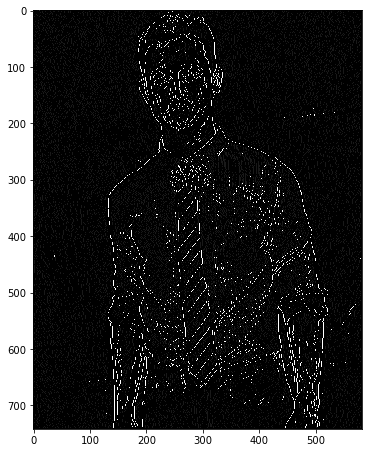

In [107]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.08):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)
res,weak,strong = threshold(op)
visualize([res],'gray')

# hysteresis

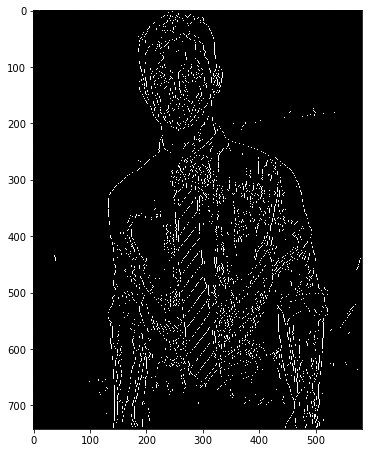

In [108]:
def hysteresis(img, weak=25, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img
visualize([hysteresis(res)],'gray')

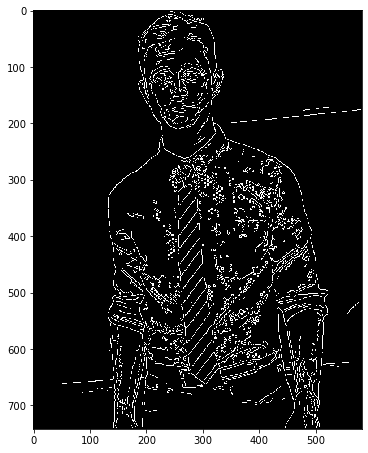

In [66]:
from  skimage.feature import canny
img=(cv2.imread('faces_imgs/5.jpg',cv2.IMREAD_GRAYSCALE))
visualize([canny(img)],'gray')